In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

---
# 1. Analysis :
---

In [2]:
# Read the dataset 
df = pd.read_csv("../Datasets/clean_politifact_train_dataset.csv")

In [4]:
df

,news,label,tokens,joined_tokens
0,pennsylvania is under a court order to count t...,0,"['pennsylvania', 'court', 'order', 'count', 'b...",pennsylvania court order count ballot election...
1,biden and democrats have dismantled border sec...,0,"['biden', 'democrat', 'dismantled', 'border', ...",biden democrat dismantled border security neva...
2,katie hobbs has voted to double our gas tax in...,1,"['katie', 'hobbs', 'voted', 'double', 'gas', '...",katie hobbs voted double gas tax run midterm e...
3,reuters reported that nancy pelosi bought mil...,0,"['reuters', 'reported', 'nancy', 'pelosi', 'bo...",reuters reported nancy pelosi bought million s...
4,it is not true that the united states was buil...,0,"['true', 'united', 'state', 'built', 'stolen',...",true united state built stolen land florida go...
...,...,...,...,...
17085,i fought to bring about the largest private se...,1,"['fought', 'bring', 'largest', 'private', 'sec...",fought bring largest private sector infrastruc...
17086,when george bush said we should not investigat...,1,"['george', 'bush', 'said', 'investigate', 'gov...",george bush said investigate government respon...
17087,sarah palin was repeating abraham lincolns wor...,1,"['sarah', 'palin', 'repeating', 'abraham', 'li...",sarah palin repeating abraham lincoln word dis...
17088,he admits he still does not know how to use a ...,1,"['admits', 'still', 'know', 'use', 'computer',...",admits still know use computer send e mail lat...


In [3]:
# replace a string to a list 
df['tokens'] = df['tokens'].apply(lambda x : x.removeprefix('[').removesuffix(']').replace("'",'').split(','))

In [ ]:
# Counting words occurneces (CountVectorizer is correct though)
from collections import Counter
def find_occurences(strings:str):
    counter = Counter()
    for string in strings:
        counter.update(string)
    return dict(counter)

In [ ]:
# Apply the counting logic
token_counts = df.groupby('label')['tokens'].apply(find_occurences).reset_index()

In [7]:
token_counts

,label,level_1,tokens
0,0,pennsylvania,7.0
1,0,court,4805.0
2,0,order,2665.0
3,0,count,1501.0
4,0,ballot,4024.0
...,...,...,...
161479,1,admits,1.0
161480,1,techie,1.0
161481,1,unappreciative,1.0
161482,1,palmpilot,1.0


In [ ]:
# Splitting the words based on classes
fake_words = token_counts[token_counts['label'] == 1]
real_words = token_counts[token_counts['label'] == 0]

In [ ]:
# Sorting based on word counts 
top_fake = fake_words.sort_values(by='tokens', ascending=False).head(20)
top_real = real_words.sort_values(by='tokens',ascending=False).head(20)

In [ ]:
# Plot most frequent words
def plot_most_frequent_words_per_class(classe,legend:str):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='tokens', y='level_1', data=classe, palette='viridis',legend=False,hue='level_1')
    plt.xlabel('Frequency')
    plt.ylabel('Token')
    plt.title(f'Top 20 Most Frequent Tokens in {legend.capitalize()} Class')
    plt.tight_layout()
    plt.show()

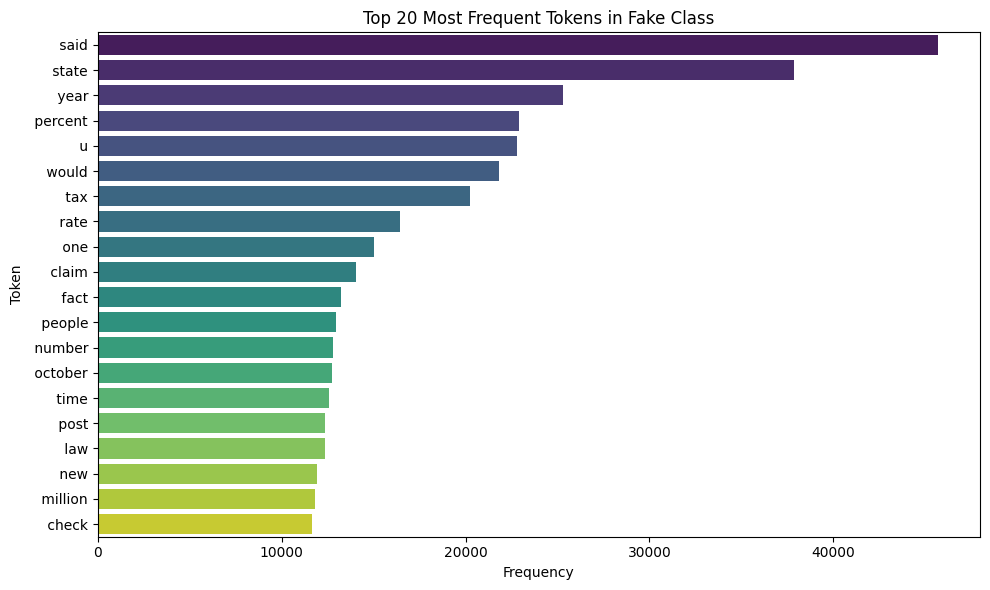

In [11]:
plot_most_frequent_words_per_class(top_fake,"fake")

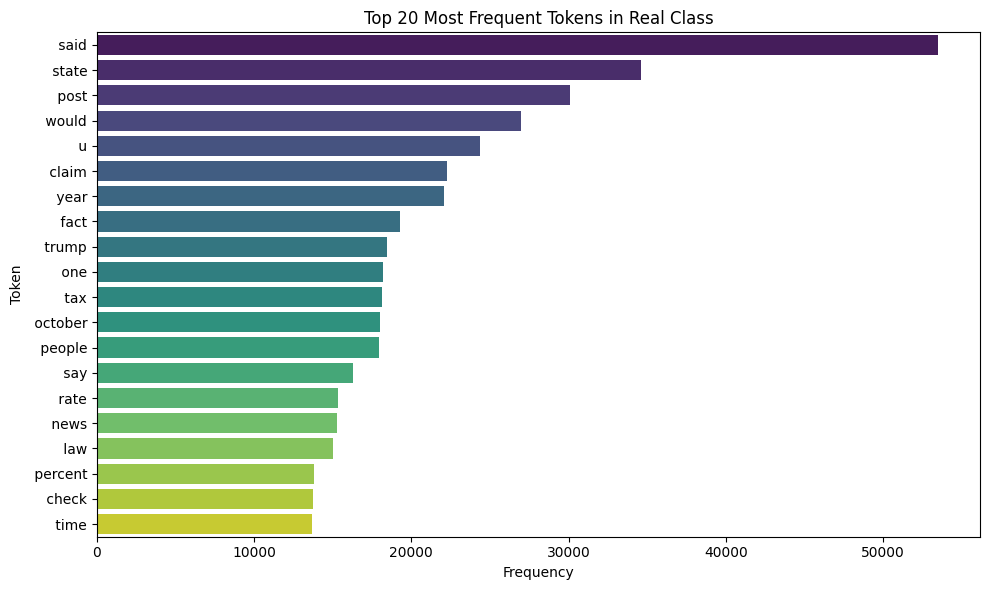

In [12]:
plot_most_frequent_words_per_class(top_real,"real")

- Based on this visualisations we see that words like ___said___ and ___state___ are frequentely occuring in the both fake and real news.We could consider them as neutral words thus they could be useless we could remove them but since we will use TF-IDF it will be as a good approach to keep them and assigning a low weights.
- In addition we could see that __trump__ word is frequent only in real news,wich constructs the assumption of deceiving the model by using this word on a fake new. this one will be taken in consideration.
- The term ___u___ is very frequent in both new and fake news but it doesn't have any significant information to get from,as a conclusion we will remove it.

In [ ]:
# Removing the u function word 
def remove_u(li:str):
    return [word.strip() for word in li if word.strip() != 'u']

In [5]:
df['tokens'] = df['tokens'].apply(remove_u)

In [15]:
token_counts = df.groupby('label')['tokens'].apply(find_occurences).reset_index()
# # PLot the word occurences based on each class 
fake_words = token_counts[token_counts['label'] == 1]
real_words = token_counts[token_counts['label'] == 0]
top_fake = fake_words.sort_values(by='tokens', ascending=False).head(20)
top_real = real_words.sort_values(by='tokens',ascending=False).head(20)

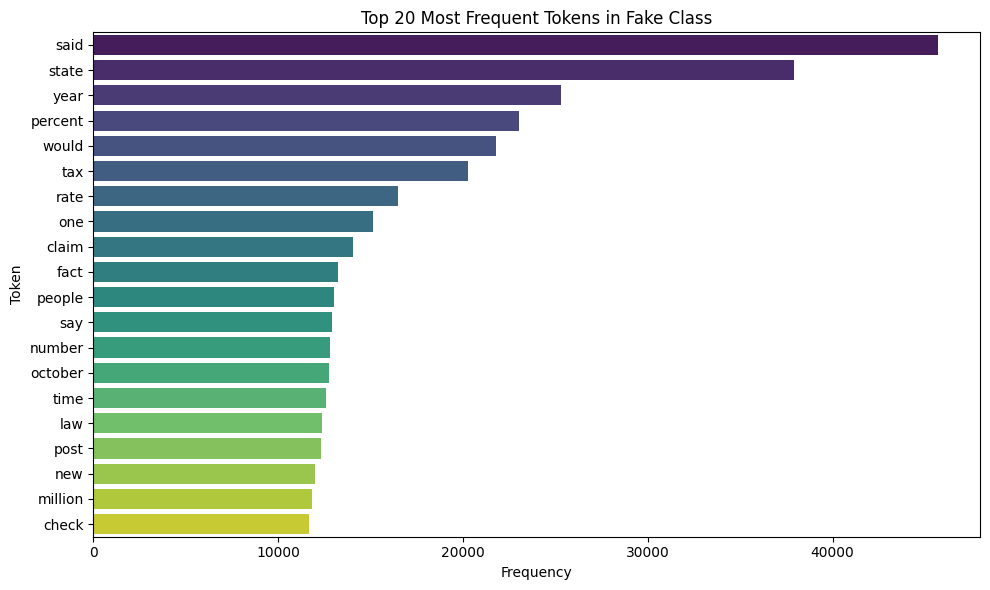

In [16]:
plot_most_frequent_words_per_class(top_fake,"fake")

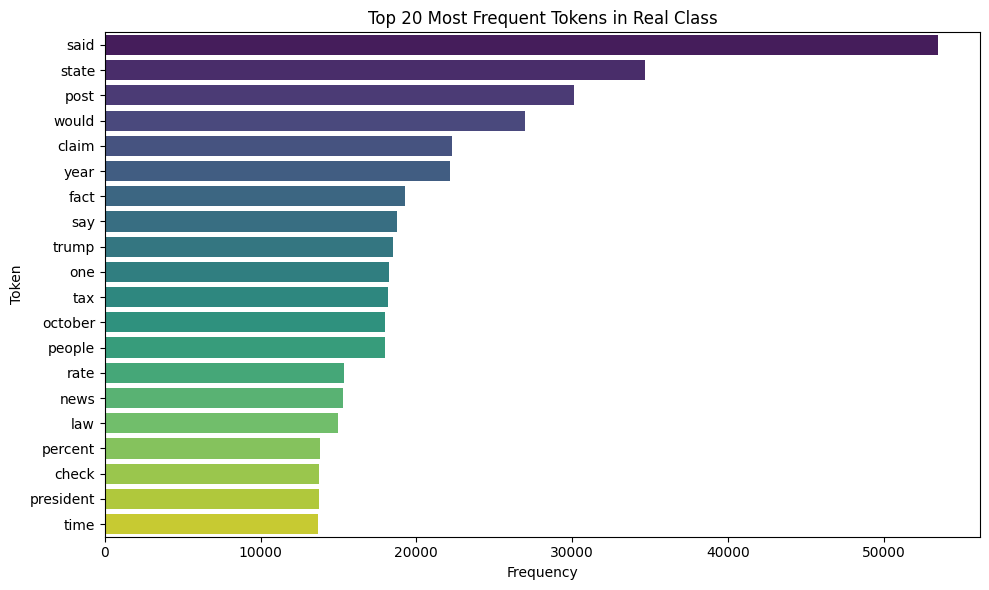

In [17]:
plot_most_frequent_words_per_class(top_real,"real")

In [6]:
# Generate the new join tokens 
df['joined_tokens'] = df['tokens'].apply(lambda x : ' '.join(x))

In [19]:
df

,news,label,tokens,joined_tokens
0,pennsylvania is under a court order to count t...,0,"[pennsylvania, court, order, count, ballot, el...",pennsylvania court order count ballot election...
1,biden and democrats have dismantled border sec...,0,"[biden, democrat, dismantled, border, security...",biden democrat dismantled border security neva...
2,katie hobbs has voted to double our gas tax in...,1,"[katie, hobbs, voted, double, gas, tax, run, m...",katie hobbs voted double gas tax run midterm e...
3,reuters reported that nancy pelosi bought mil...,0,"[reuters, reported, nancy, pelosi, bought, mil...",reuters reported nancy pelosi bought million s...
4,it is not true that the united states was buil...,0,"[true, united, state, built, stolen, land, flo...",true united state built stolen land florida go...
...,...,...,...,...
17085,i fought to bring about the largest private se...,1,"[fought, bring, largest, private, sector, infr...",fought bring largest private sector infrastruc...
17086,when george bush said we should not investigat...,1,"[george, bush, said, investigate, government, ...",george bush said investigate government respon...
17087,sarah palin was repeating abraham lincolns wor...,1,"[sarah, palin, repeating, abraham, lincoln, wo...",sarah palin repeating abraham lincoln word dis...
17088,he admits he still does not know how to use a ...,1,"[admits, still, know, use, computer, send, e, ...",admits still know use computer send e mail lat...


Analyzing individual words alone may not yield sufficient insight; hence, examining phrase-level structures through n-grams is crucial for a deeper understanding.

In [20]:
real_df = df[df['label']==0]
fake_df = df[df['label']==1]

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
# bigram
# selection only most 10k frequent n-grams as features 
# any n_grams with least than 5 occurence will be removed 
real_cv = CountVectorizer(ngram_range=(2,2), max_features=10000, min_df=5)
fake_cv = CountVectorizer(ngram_range=(2,2), max_features=10000, min_df=5)
real_bigrams = real_cv.fit_transform(real_df['joined_tokens'])
fake_bigrams = fake_cv.fit_transform(fake_df['joined_tokens'])

In [23]:
"""
counting the bigram occurences in the whole documents
"""
real_count_values = real_bigrams.toarray().sum(axis=0)
fake_count_values = fake_bigrams.toarray().sum(axis=0)

In [25]:
real_n_gram_freq = pd.DataFrame(sorted([ \
    (real_count_values[i],k) for k,i in real_cv.vocabulary_.items()],reverse=True),
        columns=['frequency','ngram'])

In [26]:
fake_n_gram_freq = pd.DataFrame(sorted([ \
    (fake_count_values[i],k) for k,i in fake_cv.vocabulary_.items()],reverse=True),
        columns=['frequency','ngram'])

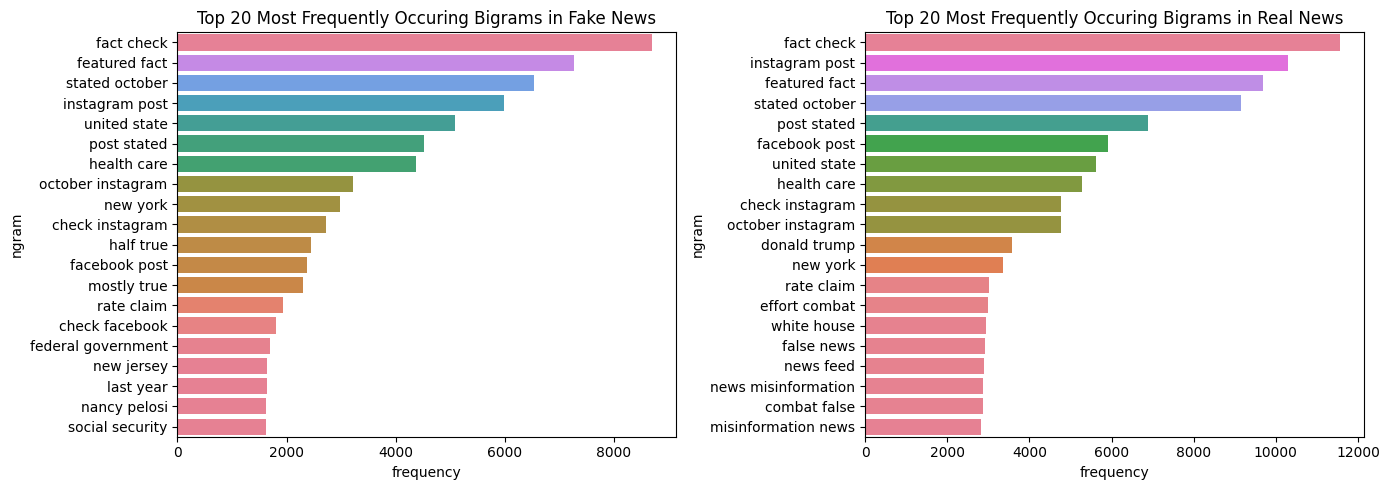

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.barplot(x='frequency', y='ngram',data=fake_n_gram_freq.head(20),palette='husl',hue='frequency',legend=False,ax=axes[0])
axes[0].set_title('Top 20 Most Frequently Occuring Bigrams in Fake News')
sns.barplot(x='frequency', y='ngram',data=real_n_gram_freq.head(20),palette='husl',hue='frequency',legend=False,ax=axes[1])
axes[1].set_title('Top 20 Most Frequently Occuring Bigrams in Real News')
plt.tight_layout()
plt.show()

- The bar plot visualization of each n-gram reveals the type of language used in news generation : 

    - Fake news predominantly uses informal, emotionally charged language that resembles social media discourse.
    - Real news tends to employ a more formal and politically precise vocabulary, reflecting institutional reporting standards
- Another thing we did remark is that the leading bi-grams are present in both fake and real news which means their impact is insignificant sunce tf-idf vectorizer will assign a low weight rate to them so we could focus on rare bi-grams for tranining.

---
# 2. Training
---

In [7]:
# Drop uneccessary data :
data = df.drop(["tokens", "news"], axis=1)

In [10]:
# Shuffle the dataset randomly and reset index
data = data.sample(frac=1).reset_index(drop=True)

In [11]:
# Separate features (news text) and target labels (truth/fake)
x = data['joined_tokens']
y = data['label']

In [12]:
# Split data into training (80%) and testing (20%) sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

> ### a. Vectorization :

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# We'll minimize features since we want to focus only on bi-grams
tf_idf_vectorizer = TfidfVectorizer(
        max_features=5000, 
        ngram_range=(1,2),     
        stop_words='english'
    )

> ### b. Logistic Regression  :

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
# Setting the logistic regression hyperparams
logistic_reg_hyperparams = {
    "lg__C": np.logspace(-4, 4, 20),
    "lg__penalty": ["l1", "l2"],
    "lg__class_weight": ["balanced"],
    "lg__max_iter": [500,1000,1500]
}
# Apply the Ranomized cross validation
# Since the dataset is imbalanced and the fake news are the positive class we will focus on the recall metric equally a f1_macro score 
estimators = RandomizedSearchCV(
    Pipeline([
        ('tfidf',tf_idf_vectorizer),
        ('lg', LogisticRegression())
    ]),
    param_distributions=logistic_reg_hyperparams,
    n_iter=50,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1
)

In [ ]:
# Train the models
estimators.fit(x_train, y_train)

c:\Users\amine\Desktop\ML\workspace\ml-env\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
145 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
145 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\amine\Desktop\ML\workspace\ml-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\amine\Desktop\ML\workspace\ml-env\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\amine\Desktop\ML\workspace\ml-env\Lib\site-pa

,estimator,Pipeline(step...egression())])
,param_distributions,"{'lg__C': array([1.0000...00000000e+04]), 'lg__class_weight': ['balanced'], 'lg__max_iter': [500, 1000, ...], 'lg__penalty': ['l1', 'l2']}"
,n_iter,50
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
# Selecting the best model
lg_model = estimators.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
# Compute the different score of the model on the test set 
def measure(model_name,y_predict,y_test):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, pos_label=1)
    recall = recall_score(y_test, y_predict, pos_label=1)
    f1 = f1_score(y_test,y_predict,pos_label=1)
    print(f"{model_name} :\n Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score : {f1}")
    return accuracy, precision, recall,f1

In [ ]:
# prredict
lg_y_pred = lg_model.predict(x_test)
# Compute score 
lg_accuracy, lg_precision, lg_recall,lg_f1 = measure("Logistic Regression", lg_y_pred, y_test)

Logistic Regression :
 Accuracy: 0.9637214745465185, Precision: 0.9580838323353293, Recall: 0.9593604263824117, F1-Score : 0.9587217043941412


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_test, y_pred, model_name):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Create display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # Plot
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


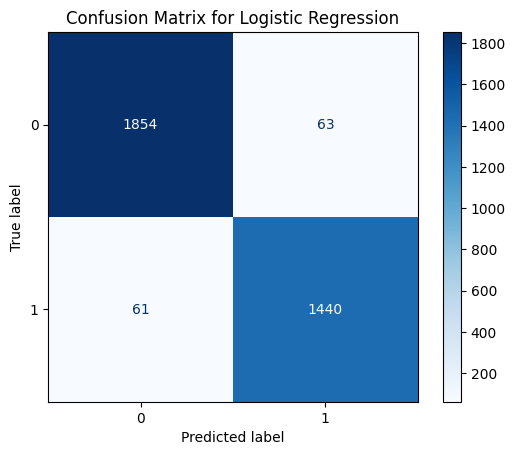

In [ ]:
# Display the confusoin matrix
plot_confusion_matrix(y_test, lg_y_pred, "Logistic Regression")

> ### c. Naive Bayes :

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Define hyperparameters Nayes Bayes
nb_hyperparams = {
    "nb__alpha": np.logspace(-3, 1, 20) 
}

nb_estimators = RandomizedSearchCV(
    Pipeline([
        ('tfidf', tf_idf_vectorizer),
        ('nb', MultinomialNB())
    ]),
    param_distributions=nb_hyperparams,
    n_iter=25,
    scoring='f1_macro',
    cv=3,
    random_state=42,
    n_jobs=-1
)

In [28]:
nb_estimators.fit(x_train, y_train)

c:\Users\amine\Desktop\ML\workspace\ml-env\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 20 is smaller than n_iter=25. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,estimator,Pipeline(step...inomialNB())])
,param_distributions,{'nb__alpha': array([1.0000...00000000e+01])}
,n_iter,25
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [29]:
nb_model = nb_estimators.best_estimator_

In [30]:
nb_y_pred = nb_model.predict(x_test)
nb_accuracy, nb_precision, nb_recall,nb_f1= measure("Naive Bayes", nb_y_pred, y_test)

Naive Bayes :
 Accuracy: 0.7638970157987127, Precision: 0.7003464203233256, Recall: 0.8081279147235176, F1-Score : 0.7503866377977111


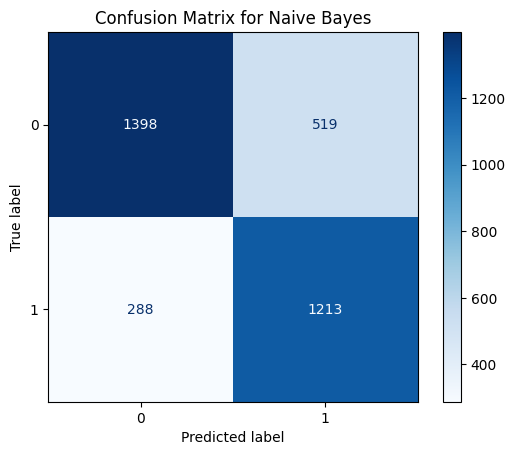

In [31]:
plot_confusion_matrix(y_test, nb_y_pred, "Naive Bayes")

> ### d. Random Forest :

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_reg_hyperparams = {
    "rf__n_estimators": [50, 100, 200],
    "rf__max_depth": [None, 10, 30, 50],
    "rf__class_weight": ["balanced", "balanced_subsample"],
}

pipeline = Pipeline([
    ('tfidf',tf_idf_vectorizer),
    ('rf', RandomForestClassifier())
])

rf_estimators = RandomizedSearchCV(
    pipeline,
    param_distributions=rf_reg_hyperparams,
    n_iter=20,
    scoring='f1_macro',         # BEST METRIC FOR FAKE NEWS
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


In [33]:
rf_estimators.fit(x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'rf__class_weight': ['balanced', 'balanced_subsample'], 'rf__max_depth': [None, 10, ...], 'rf__n_estimators': [50, 100, ...]}"
,n_iter,20
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [34]:
rf_model = rf_estimators.best_estimator_

In [35]:
rf_y_pred = rf_model.predict(x_test)
rf_accuracy, rf_precision, rf_recall, rf_f1= measure("Random Forest", rf_y_pred, y_test)

Random Forest :
 Accuracy: 0.9882972498537156, Precision: 0.9939148073022313, Recall: 0.9793471019320453, F1-Score : 0.9865771812080537


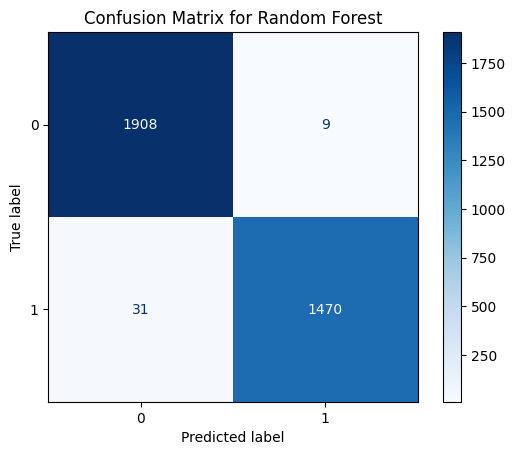

In [36]:
plot_confusion_matrix(y_test, rf_y_pred, "Random Forest")

> ### e. K-Nearest Neighbors  :

In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn_hyperparams = {
    "knn__n_neighbors": [3,5,7,9],
    "knn__weights": ["uniform", "distance"],
}
knn_estimators = RandomizedSearchCV(
    Pipeline([
        ('tfidf', tf_idf_vectorizer),
        ('knn', KNeighborsClassifier())
    ]),
    param_distributions=knn_hyperparams,
    n_iter=25,
    scoring='f1_macro',
    cv=3,
    random_state=42,
    n_jobs=-1
)

In [38]:
knn_estimators.fit(x_train, y_train)

c:\Users\amine\Desktop\ML\workspace\ml-env\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=25. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'knn__n_neighbors': [3, 5, ...], 'knn__weights': ['uniform', 'distance']}"
,n_iter,25
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [39]:
knn_model = knn_estimators.best_estimator_

In [40]:
knn_y_pred = knn_model.predict(x_test)
knn_accuracy, knn_precision, knn_recall,knn_f1= measure("K-Nearest Neighbors", knn_y_pred, y_test)

K-Nearest Neighbors :
 Accuracy: 0.6597425394967817, Precision: 0.6135752688172043, Recall: 0.6082611592271818, F1-Score : 0.6109066577450653


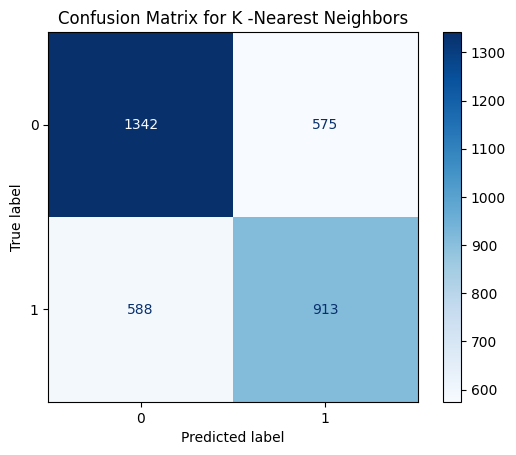

In [41]:
plot_confusion_matrix(y_test, knn_y_pred, "K -Nearest Neighbors")

In [42]:
metrics = {
    "logistic_regression": (lg_accuracy, lg_precision, lg_recall,lg_f1),
    "naive_bayes": (nb_accuracy, nb_precision, nb_recall,nb_f1),
    "random_forest": (rf_accuracy, rf_precision, rf_recall,rf_f1),
    "k_nearest_neighbors": (knn_accuracy, knn_precision, knn_recall,knn_f1)
}

# 3 . Model Evaluation & selection  : 

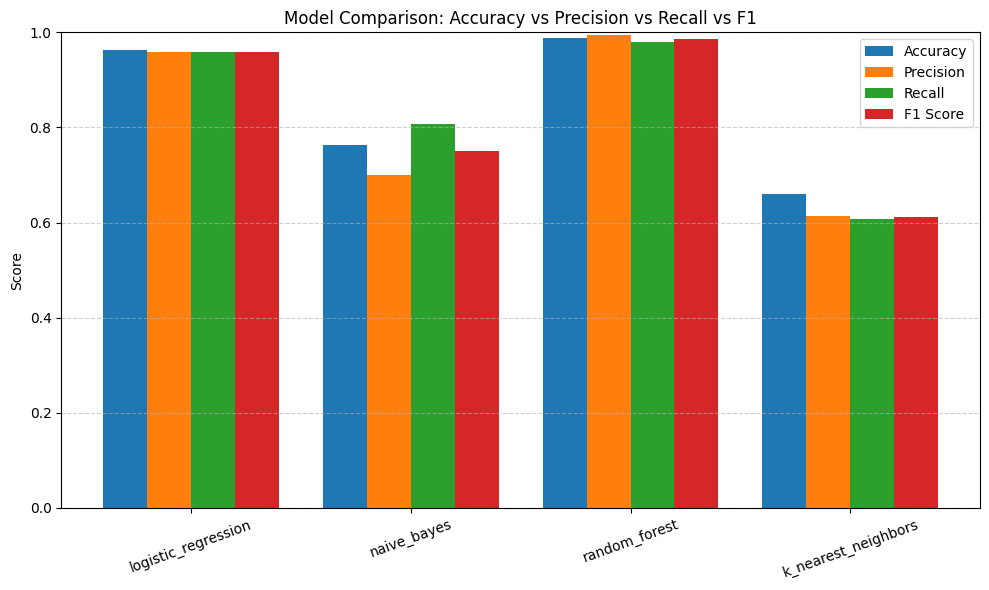

In [43]:
# Extract model names and values
models = list(metrics.keys())
accuracies = [metrics[m][0] for m in models]
precisions = [metrics[m][1] for m in models]
recalls = [metrics[m][2] for m in models]
f1s = [metrics[m][3] for m in models]

# Set bar width and positions
x = np.arange(len(models))
width = 0.2  # smaller width so all bars fit

# Create the plot
plt.figure(figsize=(10,6))
plt.bar(x - 1.5*width, accuracies, width, label='Accuracy')
plt.bar(x - 0.5*width, precisions, width, label='Precision')
plt.bar(x + 0.5*width, recalls, width, label='Recall')
plt.bar(x + 1.5*width, f1s, width, label='F1 Score')

# Add labels and formatting
plt.xticks(x, models, rotation=20)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy vs Precision vs Recall vs F1")
plt.legend()
plt.ylim(0, 1)  # assuming metrics are between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Display the chart
plt.tight_layout()
plt.show()

Based on these evaluations random forest tends to be the best one since its f1-score and precision take the lead in the evaluation score 

In [51]:
import json
# Get the hyper params 
tf_idf_params = rf_model['tfidf'].get_params()
rf_params = rf_model['rf'].get_params()
config = {
    "tfidf": {
        "max_features": tf_idf_params["max_features"],
        "ngram_range": tf_idf_params["ngram_range"],
        "stop_words": tf_idf_params["stop_words"],
    },
    "rf": {
        "n_estimators": rf_params["n_estimators"],
        "max_depth": rf_params["max_depth"],
        "class_weight": rf_params["class_weight"],
        "max_features": rf_params["max_features"],
    }
}

with open('../Config/params.json','w') as f:
    json.dump(config, f, indent=2)


In [52]:
# Save the trained model 
import joblib
joblib.dump(rf_model, "../Models/pipeline_model.joblib")

['../Models/pipeline_model.joblib']

---
Done 
---
